# Kirby_Detection_Ensemble

## Environment Setting

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install roboflow

     |████████████████████████████████| 145 kB 42.1 MB/s 
     |████████████████████████████████| 178 kB 63.3 MB/s 
     |████████████████████████████████| 1.1 MB 49.0 MB/s 
     |████████████████████████████████| 67 kB 7.8 MB/s 
     |████████████████████████████████| 54 kB 4.0 MB/s 
     |████████████████████████████████| 138 kB 76.9 MB/s 
     |████████████████████████████████| 596 kB 68.3 MB/s 
     |████████████████████████████████| 63 kB 2.3 MB/s 
  Created wheel for roboflow: filename=roboflow-0.2.4-py3-none-any.whl size=21356 sha256=3bc3b43c3b31eb8c866cd8bc4462dac7e5d36c11e187ce7867ed6fd18bf28154
  Stored in directory: /root/.cache/pip/wheels/b7/2c/60/3733c0e323b1d7aec00f852264314bf6c48192c8e1dc92b3ee
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=24b3bc65aac69b3d9042e89de8cac1d2c7161ba3a953969450e51362c3e23ec5
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built roboflow wge

In [3]:
!pip install ensemble-boxes

In [4]:
from roboflow import Roboflow

rf = Roboflow(api_key="vBpZoEq9j50qc2xeJ8xZ")
project = rf.workspace("jinxuan-tang").project("kirby-detection---ai-camp-crash-course")
dataset = project.version(2).download("yolov5")

loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to Kirby-Detection---AI-Camp-Crash-Course-2 in yolov5pytorch:: 100%|██████████| 270/270 [00:00<00:00, 1082.34it/s]


In [5]:
! pip install wandb -qqq

     |████████████████████████████████| 1.8 MB 20.3 MB/s 
     |████████████████████████████████| 144 kB 11.7 MB/s 
     |████████████████████████████████| 181 kB 11.3 MB/s 
     |████████████████████████████████| 63 kB 1.9 MB/s 


In [6]:
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [7]:
import os
os.chdir('/content')

In [8]:
!git clone https://github.com/ultralytics/yolov5  # clone
%cd yolov5
%pip install -qr requirements.txt  # install

import torch
from yolov5 import utils
display = utils.notebook_init()  # checks

YOLOv5 🚀 v6.1-162-g2611477 torch 1.11.0+cu113 CUDA:0 (Tesla T4, 15110MiB)


Setup complete ✅ (2 CPUs, 12.7 GB RAM, 38.7/78.2 GB disk)


In [9]:
yolo_loc = os.getcwd()
print(os.getcwd())
data_loc = '/content/Kirby-Detection---AI-Camp-Crash-Course-2'

/content/yolov5


In [10]:
import shutil
shutil.copytree(data_loc, yolo_loc + '/Kirby-Detection---AI-Camp-Crash-Course-2')

'/content/yolov5/Kirby-Detection---AI-Camp-Crash-Course-2'

In [11]:
import numpy as np
from tqdm.notebook import tqdm
tqdm.pandas()
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import glob

import sys

from IPython.display import display
from ensemble_boxes import *
from PIL import Image
import torch

## Ensemble

In [12]:
## Helper Function

In [13]:
def load_model(ckpt_path):
    model = torch.hub.load('/content/yolov5/','custom',path=ckpt_path, source='local',force_reload=True)
    model.conf = 0.25 #0.1  
    model.iou  = 0.4 #0.2 
    model.classes = None   
    model.multi_label = False 
    model.max_det = 1000  
    return model

def get_prediction(model, img):
    results = model(img, size=3000, augment=True)
    preds   = results.pandas().xyxy[0]
    bboxes  = preds[['xmin','ymin','xmax','ymax']].values
    print(bboxes)
    if len(bboxes) > 0:
        return bboxes, preds['confidence'].values
    return [], []

def wbf(bboxes, confs):
    boxes =  [bbox/1280 for bbox in bboxes]
    scores = [conf for conf in confs]
    labels = [np.ones(conf.shape[0]) for conf in confs]
    
    boxes, scores, labels = weighted_boxes_fusion(boxes, scores, labels, weights=[1,1], iou_thr=0.2, skip_box_thr=0.001)
    
    boxes = boxes*(1280-1)
    return boxes, scores, labels

In [14]:
def load_image(image_path):
    return cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)

def draw_bboxes(img, bboxes, classes, class_ids, colors = None, show_classes = None, bbox_format = 'yolo', class_name = False, line_thickness = 2,scores=None):  
     
    image = img.copy()
    show_classes = classes if show_classes is None else show_classes
    colors = (0, 255 ,0) if colors is None else colors
    
    if bbox_format == 'yolo':
        
        for idx in range(len(bboxes)):  
            
            bbox  = bboxes[idx]
            cls   = classes[idx]
            score   = scores[idx]
            cls_id = class_ids[idx]
            color = colors[cls_id] if type(colors) is list else colors
            
            if cls in show_classes:
            
                x1 = round(float(bbox[0])*image.shape[1])
                y1 = round(float(bbox[1])*image.shape[0])
                w  = round(float(bbox[2])*image.shape[1]/2) #w/2 
                h  = round(float(bbox[3])*image.shape[0]/2)

                voc_bbox = (x1-w, y1-h, x1+w, y1+h)
                plot_one_box(voc_bbox, 
                             image,
                             color = color,
                             label = cls if class_name else str(get_label(cls)),
                             line_thickness = line_thickness,score=score)
            
    elif bbox_format == 'coco':
        
        for idx in range(len(bboxes)):  
            
            bbox  = bboxes[idx]
            cls   = classes[idx]
            cls_id = class_ids[idx]
            score   = scores[idx]
            color = colors[cls_id] if type(colors) is list else colors
            
            if cls in show_classes:            
                x1 = int(round(bbox[0]))
                y1 = int(round(bbox[1]))
                w  = int(round(bbox[2]))
                h  = int(round(bbox[3]))

                voc_bbox = (x1, y1, x1+w, y1+h)
                plot_one_box(voc_bbox, 
                             image,
                             color = color,
                             label = cls if class_name else str(cls_id),
                             line_thickness = line_thickness,score=score)

    elif bbox_format == 'voc_pascal':
        
        for idx in range(len(bboxes)):  
            
            bbox  = bboxes[idx]
            cls   = classes[idx]
            cls_id = class_ids[idx]
            score   = scores[idx]
            color = colors[cls_id] if type(colors) is list else colors
            
            if cls in show_classes: 
                x1 = int(round(bbox[0]))
                y1 = int(round(bbox[1]))
                x2 = int(round(bbox[2]))
                y2 = int(round(bbox[3]))
                voc_bbox = (x1, y1, x2, y2)
                plot_one_box(voc_bbox, 
                             image,
                             color = color,
                             label = cls if class_name else str(cls_id),
                             line_thickness = line_thickness,score=score)
    else:
        raise ValueError('wrong bbox format')

    return image

def show_img(img, bboxes, bbox_format='yolo',scores=None):
    names  = ['Kirby']*len(bboxes)
    labels = [0]*len(bboxes)
    img    = draw_bboxes(img = img,
                           bboxes = bboxes, 
                           classes = names,
                           class_ids = labels,
                           class_name = True, 
                           colors = colors, 
                           bbox_format = bbox_format,
                           line_thickness = 2,scores=scores)
    return Image.fromarray(img).resize((800, 400))    

np.random.seed(32)
colors = [(np.random.randint(255), np.random.randint(255), np.random.randint(255))\
          for idx in range(1)]

In [15]:
def voc2yolo(bboxes, image_height=416, image_width=416):
    """
    voc  => [x1, y1, x2, y2]
    yolo => [xmid, ymid, w, h] (normalized)
    """
    
    bboxes = bboxes.copy().astype(float) # otherwise all value will be 0 as voc_pascal dtype is np.int
    
    bboxes[..., [0, 2]] = bboxes[..., [0, 2]]/ image_width
    bboxes[..., [1, 3]] = bboxes[..., [1, 3]]/ image_height
    
    w = bboxes[..., 2] - bboxes[..., 0]
    h = bboxes[..., 3] - bboxes[..., 1]
    
    bboxes[..., 0] = bboxes[..., 0] + w/2
    bboxes[..., 1] = bboxes[..., 1] + h/2
    bboxes[..., 2] = w
    bboxes[..., 3] = h
    
    return bboxes

def yolo2voc(bboxes, image_height=416, image_width=416):
    """
    yolo => [xmid, ymid, w, h] (normalized)
    voc  => [x1, y1, x2, y2]
    
    """ 
    bboxes = bboxes.copy().astype(float) # otherwise all value will be 0 as voc_pascal dtype is np.int
    
    bboxes[..., [0, 2]] = bboxes[..., [0, 2]]* image_width
    bboxes[..., [1, 3]] = bboxes[..., [1, 3]]* image_height
    
    bboxes[..., [0, 1]] = bboxes[..., [0, 1]] - bboxes[..., [2, 3]]/2
    bboxes[..., [2, 3]] = bboxes[..., [0, 1]] + bboxes[..., [2, 3]]
    
    return bboxes

def coco2yolo(bboxes, image_height=416, image_width=416):
    """
    coco => [xmin, ymin, w, h]
    yolo => [xmid, ymid, w, h] (normalized)
    """
    
    bboxes = bboxes.copy().astype(float) # otherwise all value will be 0 as voc_pascal dtype is np.int
    
    # normolizinig
    bboxes[..., [0, 2]]= bboxes[..., [0, 2]]/ image_width
    bboxes[..., [1, 3]]= bboxes[..., [1, 3]]/ image_height
    
    # converstion (xmin, ymin) => (xmid, ymid)
    bboxes[..., [0, 1]] = bboxes[..., [0, 1]] + bboxes[..., [2, 3]]/2
    
    return bboxes

def yolo2coco(bboxes, image_height=416, image_width=416):
    """
    yolo => [xmid, ymid, w, h] (normalized)
    coco => [xmin, ymin, w, h]
    
    """ 
    bboxes = bboxes.copy().astype(float) # otherwise all value will be 0 as voc_pascal dtype is np.int
    
    # denormalizing
    bboxes[..., [0, 2]]= bboxes[..., [0, 2]]* image_width
    bboxes[..., [1, 3]]= bboxes[..., [1, 3]]* image_height
    
    # converstion (xmid, ymid) => (xmin, ymin) 
    bboxes[..., [0, 1]] = bboxes[..., [0, 1]] - bboxes[..., [2, 3]]/2
    
    return bboxes

def voc2coco(bboxes, image_height=416, image_width=416):
    bboxes  = voc2yolo(bboxes, image_height, image_width)
    bboxes  = yolo2coco(bboxes, image_height, image_width)
    return bboxes

def coco2voc(bboxes, image_height=416, image_width=416):
    bboxes  = coco2yolo(bboxes, image_height, image_width)
    bboxes  = yolo2voc(bboxes, image_height, image_width)
    return bboxes

In [16]:
def plot_one_box(x, img, color=None, label=None, line_thickness=None,score=None):
    tl = line_thickness or round(0.002 * (img.shape[0] + img.shape[1]) / 2) + 1  # line/font thickness
    color = color or [random.randint(0, 255) for _ in range(3)]
    c1, c2 = (int(x[0]), int(x[1])), (int(x[2]), int(x[3]))
    cv2.rectangle(img, c1, c2, color, thickness=tl, lineType=cv2.LINE_AA)
    label=label+"{:.2f}%".format(score)
    if label:
        tf = max(tl - 1, 1)  # font thickness
        t_size = cv2.getTextSize(label, 0, fontScale=tl / 3, thickness=tf)[0]
        c2 = c1[0] + t_size[0], c1[1] - t_size[1] - 3
        cv2.rectangle(img, c1, c2, color, -1, cv2.LINE_AA)  # filled
        cv2.putText(img, label, (c1[0], c1[1] - 2), 0, tl / 3, [225, 255, 255], thickness=tf, lineType=cv2.LINE_AA)

In [17]:
m1_path = '/content/drive/MyDrive/AI Camp/Crash Course/train/weights/best.pt'
m2_path = '/content/drive/MyDrive/AI Camp/Crash Course/trainm/weights/best.pt'

m1 = load_model(m1_path)
m2 = load_model(m2_path)

requirements: matplotlib>=3.2.2 not found and is required by YOLOv5, attempting auto-update...

requirements: PyYAML>=5.3.1 not found and is required by YOLOv5, attempting auto-update...

requirements: requests>=2.23.0 not found and is required by YOLOv5, attempting auto-update...

requirements: seaborn>=0.11.0 not found and is required by YOLOv5, attempting auto-update...

requirements: 4 packages updated per /content/yolov5/requirements.txt
requirements: ⚠️ Restart runtime or rerun command for updates to take effect

YOLOv5 🚀 v6.1-162-g2611477 torch 1.11.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
Model summary: 213 layers, 7012822 parameters, 0 gradients
Adding AutoShape... 
requirements: matplotlib>=3.2.2 not found and is required by YOLOv5, attempting auto-update...

requirements: PyYAML>=5.3.1 not found and is required by YOLOv5, attempting auto-update...

requirements: 2 packages updated per /content/yolov5/requirements.txt
requirements: ⚠️ Restart runtime or rerun co

In [18]:
p = '/content/Kirby-Detection---AI-Camp-Crash-Course-2/test/images/104_jpg.rf.00af1d06471c42baab7f3a50eec774f6.jpg'

[[     247.35      309.26      272.79      349.14]]
[[     246.57      308.43      272.57      349.36]]
[[     247.35      309.26      272.79      349.14]] [     0.7897] [[     246.57      308.43      272.57      349.36]] [    0.62974] [[246 308  25  40]] [    0.70972]
[[246 308  25  40]] [    0.70972]


YOLOV5s6 Predictions 


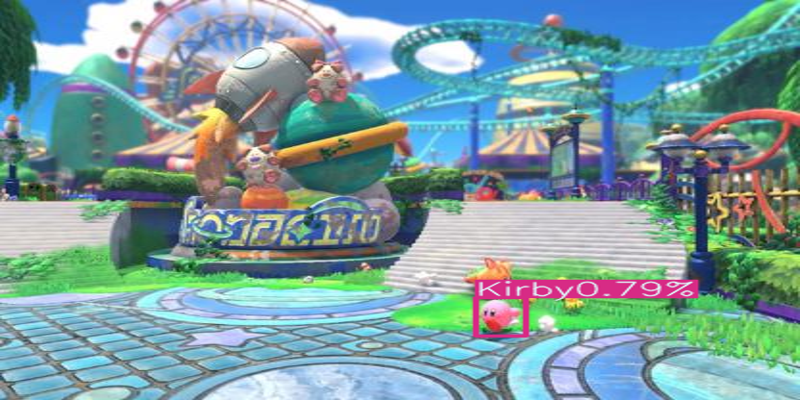



YoloV5n6 Predictions 


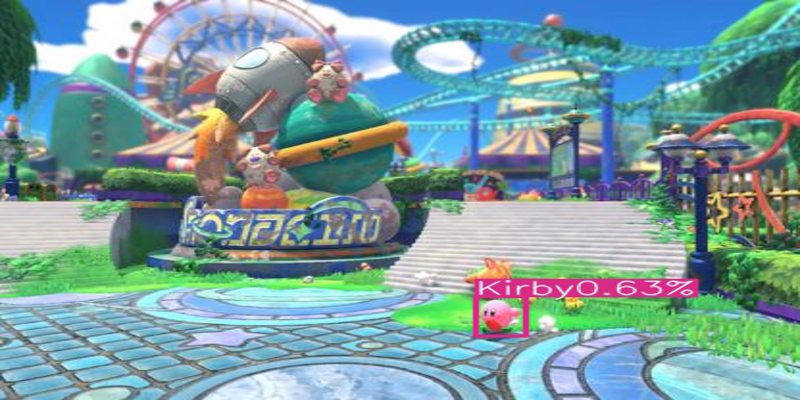



Ensemble (WBF) Predictions 


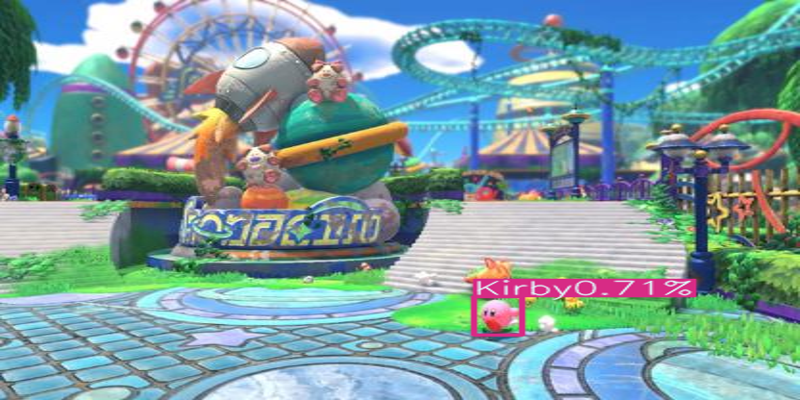

In [20]:
img = cv2.imread(p)[...,::-1]
b1, c1 = get_prediction(m1, img)
b2, c2 = get_prediction(m2, img)
if len(b1) > 0:
    b1 = np.array(b1)
if len(b2) > 0:
    b2 = np.array(b2)

# voc  => [x1, y1, x2, y2]
# coco => [xmin, ymin, w, h]
# model predictions are in voc format
# for testing we need predictions in coco format
if len(b1) > 0 and len(b2) > 0:
    b, c, labels = wbf([b1, b2], [c1, c2])
    b = voc2coco(b).astype(int)
elif len(b1) > 0:
    b, c = voc2coco(b1, image_height=416, image_width=416), c1
elif len(b2) > 0:
    b, c = voc2coco(b2, image_height=416, image_width=416), c2
else:
    b, c = [], []
print(b1, c1, b2, c2, b, c)
print(b, c)

if True: #len(b1) > 0 and len(b2) > 0:
    print('\n\nYOLOV5s6 Predictions ')
    if len(b1) > 0:            
        display(show_img(img, b1, bbox_format='voc_pascal',scores=c1))
    else:        
        display(show_img(img, [], bbox_format='voc_pascal',scores=c1))

    print('\n\nYoloV5n6 Predictions ')  
    if len(b2) > 0:
        display(show_img(img, b2, bbox_format='voc_pascal',scores=c2))
    else:
        display(show_img(img, [], bbox_format='voc_pascal',scores=c2))

    print('\n\nEnsemble (WBF) Predictions ')
    if len(b) > 0: 
        display(show_img(img, b, bbox_format='coco',scores=c))
    else:
        display(show_img(img, [], bbox_format='coco',scores=None))